In [22]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import cross_val_score
import math

## Read in Data

In [2]:
df = pd.read_csv("chessData.csv")
df.head()

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12958035 entries, 0 to 12958034
Data columns (total 2 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   FEN         object
 1   Evaluation  object
dtypes: object(2)
memory usage: 197.7+ MB


In [4]:
df["FEN"]

0           rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...
1           rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...
2           rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...
3           rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...
4           rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...
                                  ...                        
12958030    r1bqkb1r/pp3ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1P...
12958031    r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1...
12958032    r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1BN2N2/PP2Q...
12958033    r2qkb1r/pp1b1ppp/1n2p3/n2pP3/3P1P2/1BN2N2/PP2Q...
12958034    r2qkb1r/pp1b1ppp/1n2p3/n2pP3/3P1P2/2N2N2/PPB1Q...
Name: FEN, Length: 12958035, dtype: object

## Format Data

In [5]:
df = df[~df['Evaluation'].str.startswith('#')]
df['Evaluation'] = df['Evaluation'].str.replace('[^\d-]+', '', regex=True).astype(int)
df["Evaluation"].value_counts()

Evaluation
 0       1261356
 13       157897
-13       148689
 46        41674
 53        41404
          ...   
 5858          1
-4756          1
-3586          1
 8580          1
-4516          1
Name: count, Length: 13432, dtype: int64

In [6]:
df[["row1", "row2", "row3", "row4", "row5", "row6", "row7", "leftover_data"]] = df["FEN"].str.split('/', expand=True)

In [7]:
df.drop(columns=['FEN'], inplace=True)
df.head()

,Evaluation,row1,row2,row3,row4,row5,row6,row7,leftover_data
0,-10,rnbqkbnr,pppppppp,8,8,4P3,8,PPPP1PPP,RNBQKBNR b KQkq - 0 1
1,56,rnbqkbnr,pppp1ppp,4p3,8,4P3,8,PPPP1PPP,RNBQKBNR w KQkq - 0 2
2,-9,rnbqkbnr,pppp1ppp,4p3,8,3PP3,8,PPP2PPP,RNBQKBNR b KQkq - 0 2
3,52,rnbqkbnr,ppp2ppp,4p3,3p4,3PP3,8,PPP2PPP,RNBQKBNR w KQkq - 0 3
4,-26,rnbqkbnr,ppp2ppp,4p3,3p4,3PP3,8,PPPN1PPP,R1BQKBNR b KQkq - 1 3


In [8]:
df[["row8","active_color", "castle", "en_passant", "halfmove_clock", "fullmove_num"]] = df["leftover_data"].str.split(" ", expand=True)

In [9]:
df.drop(columns=['leftover_data'], inplace=True)

In [10]:
df["active_color"] = df["active_color"].map({"b": 1, "w": 0})
df.head()

,Evaluation,row1,row2,row3,row4,row5,row6,row7,row8,active_color,castle,en_passant,halfmove_clock,fullmove_num
0,-10,rnbqkbnr,pppppppp,8,8,4P3,8,PPPP1PPP,RNBQKBNR,1,KQkq,-,0,1
1,56,rnbqkbnr,pppp1ppp,4p3,8,4P3,8,PPPP1PPP,RNBQKBNR,0,KQkq,-,0,2
2,-9,rnbqkbnr,pppp1ppp,4p3,8,3PP3,8,PPP2PPP,RNBQKBNR,1,KQkq,-,0,2
3,52,rnbqkbnr,ppp2ppp,4p3,3p4,3PP3,8,PPP2PPP,RNBQKBNR,0,KQkq,-,0,3
4,-26,rnbqkbnr,ppp2ppp,4p3,3p4,3PP3,8,PPPN1PPP,R1BQKBNR,1,KQkq,-,1,3


In [11]:
df['halfmove_clock'] = df['halfmove_clock'].astype(int)
df['fullmove_num'] = df['fullmove_num'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12767881 entries, 0 to 12958034
Data columns (total 14 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Evaluation      int32 
 1   row1            object
 2   row2            object
 3   row3            object
 4   row4            object
 5   row5            object
 6   row6            object
 7   row7            object
 8   row8            object
 9   active_color    int64 
 10  castle          object
 11  en_passant      object
 12  halfmove_clock  int32 
 13  fullmove_num    int32 
dtypes: int32(3), int64(1), object(10)
memory usage: 1.3+ GB


In [12]:
df["castle"].value_counts()
df = pd.get_dummies(data=df,
               prefix=["castle"],
               columns=["castle"])
df.head()

,Evaluation,row1,row2,row3,row4,row5,row6,row7,row8,active_color,...,castle_Kk,castle_Kkq,castle_Kq,castle_Q,castle_Qk,castle_Qkq,castle_Qq,castle_k,castle_kq,castle_q
0,-10,rnbqkbnr,pppppppp,8,8,4P3,8,PPPP1PPP,RNBQKBNR,1,...,False,False,False,False,False,False,False,False,False,False
1,56,rnbqkbnr,pppp1ppp,4p3,8,4P3,8,PPPP1PPP,RNBQKBNR,0,...,False,False,False,False,False,False,False,False,False,False
2,-9,rnbqkbnr,pppp1ppp,4p3,8,3PP3,8,PPP2PPP,RNBQKBNR,1,...,False,False,False,False,False,False,False,False,False,False
3,52,rnbqkbnr,ppp2ppp,4p3,3p4,3PP3,8,PPP2PPP,RNBQKBNR,0,...,False,False,False,False,False,False,False,False,False,False
4,-26,rnbqkbnr,ppp2ppp,4p3,3p4,3PP3,8,PPPN1PPP,R1BQKBNR,1,...,False,False,False,False,False,False,False,False,False,False


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12767881 entries, 0 to 12958034
Data columns (total 29 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Evaluation      int32 
 1   row1            object
 2   row2            object
 3   row3            object
 4   row4            object
 5   row5            object
 6   row6            object
 7   row7            object
 8   row8            object
 9   active_color    int64 
 10  en_passant      object
 11  halfmove_clock  int32 
 12  fullmove_num    int32 
 13  castle_-        bool  
 14  castle_K        bool  
 15  castle_KQ       bool  
 16  castle_KQk      bool  
 17  castle_KQkq     bool  
 18  castle_KQq      bool  
 19  castle_Kk       bool  
 20  castle_Kkq      bool  
 21  castle_Kq       bool  
 22  castle_Q        bool  
 23  castle_Qk       bool  
 24  castle_Qkq      bool  
 25  castle_Qq       bool  
 26  castle_k        bool  
 27  castle_kq       bool  
 28  castle_q        bool  
dtypes: bool(16), int3

## Graph Data and Scale

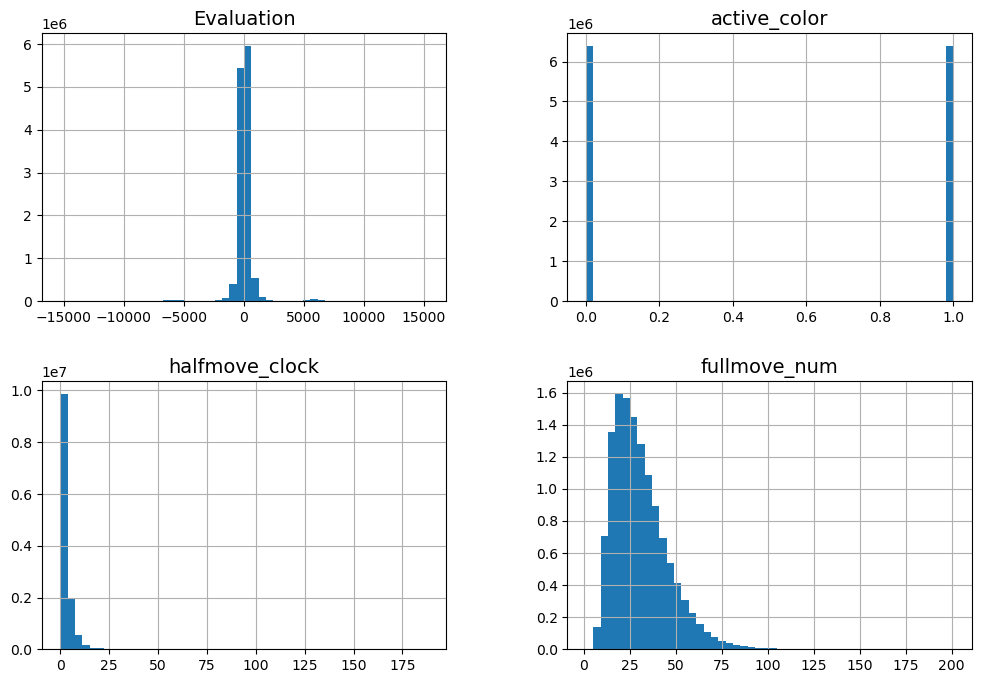

In [14]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
plt.show()

In [15]:
scaler = StandardScaler()
cols_to_scale = ["halfmove_clock", "fullmove_num"]
scaler.fit(df[cols_to_scale])
df[cols_to_scale] = scaler.transform(df[cols_to_scale])

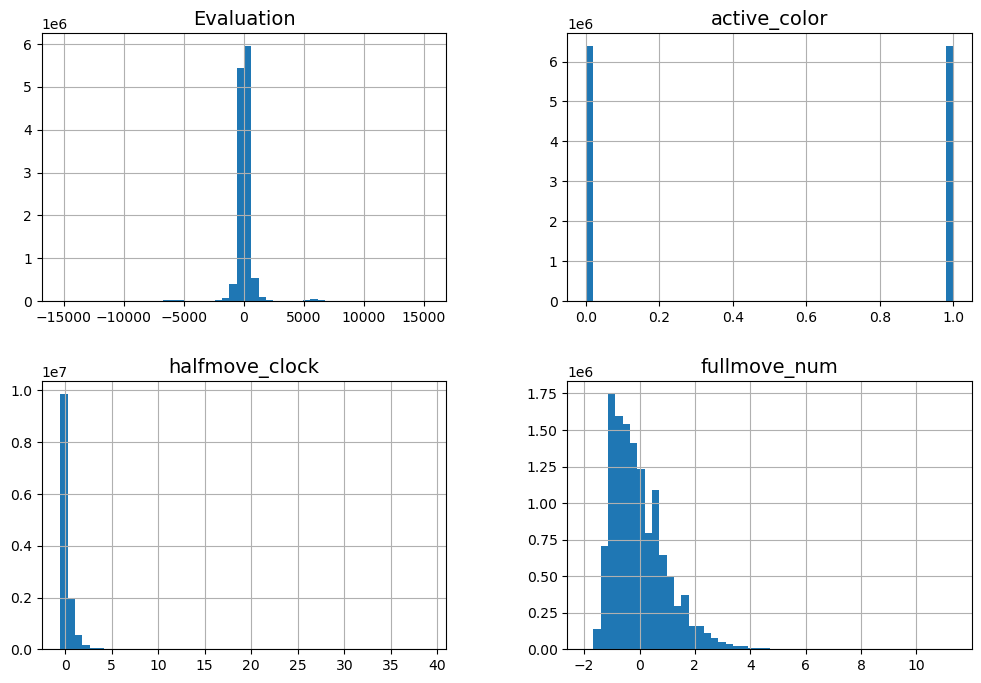

In [16]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
plt.show()

## Create Train and Test Set

In [17]:
x_train, x_test = train_test_split(df, test_size=0.2)

In [18]:
print(x_train.shape)
print(x_test.shape)

print(x_train.head())
print(x_test.head())

(10214304, 29)
(2553577, 29)
          Evaluation     row1      row2    row3     row4   row5    row6  \
11713889         228      2r5   pp1q2bk  3pppnp      6p1    4P3     1P6   
9961729         -846    r3k2r   pppbqp2  3p1n1p  b2Np1p1  2B1P3  3PB1PP   
6626077           15  r1b1k2r  1pppqppp     5n2    p2Pp3   1nP5  P3P1P1   
1233960          -79     r5k1    3n1pp1    1q5p     3pP3    3p4  2bB1N2   
2643049          -43    r2q3r    p3pP1k    b5pp  P1pP1p2   2pb4     2N5   

              row7     row8  active_color  ... castle_Kk  castle_Kkq  \
11713889  P1PQ1PPP  1R2RBK1             1  ...     False       False   
9961729     PPP3PN    R4R1K             1  ...     False       False   
6626077   1P1N1PBP  RQ2K1NR             1  ...     False       False   
1233960      4QPPP     5RK1             0  ...     False       False   
2643049   1PQ1BnPP  R1B2R1K             0  ...     False       False   

          castle_Kq  castle_Q  castle_Qk  castle_Qkq  castle_Qq  castle_k  \
11713889  

In [19]:
y_train = x_train['Evaluation'].copy()
x_train.drop('Evaluation', axis=1, inplace=True)

y_test = x_test['Evaluation'].copy()
x_test.drop('Evaluation', axis=1, inplace=True)

print(x_train.head())
print(y_train.head())

             row1      row2    row3     row4   row5    row6      row7  \
11713889      2r5   pp1q2bk  3pppnp      6p1    4P3     1P6  P1PQ1PPP   
9961729     r3k2r   pppbqp2  3p1n1p  b2Np1p1  2B1P3  3PB1PP    PPP3PN   
6626077   r1b1k2r  1pppqppp     5n2    p2Pp3   1nP5  P3P1P1  1P1N1PBP   
1233960      r5k1    3n1pp1    1q5p     3pP3    3p4  2bB1N2     4QPPP   
2643049     r2q3r    p3pP1k    b5pp  P1pP1p2   2pb4     2N5  1PQ1BnPP   

             row8  active_color en_passant  ...  castle_Kk  castle_Kkq  \
11713889  1R2RBK1             1          -  ...      False       False   
9961729     R4R1K             1          -  ...      False       False   
6626077   RQ2K1NR             1          -  ...      False       False   
1233960      5RK1             0          -  ...      False       False   
2643049   R1B2R1K             0          -  ...      False       False   

          castle_Kq  castle_Q  castle_Qk  castle_Qkq  castle_Qq  castle_k  \
11713889      False     False      Fals

In [36]:
x_train_np = x_train.values
y_train_np = y_train.values

x_test_np = x_test.values
y_test_np = y_test.values
x_train_np

array([['2r5', 'pp1q2bk', '3pppnp', ..., False, False, False],
       ['r3k2r', 'pppbqp2', '3p1n1p', ..., False, True, False],
       ['r1b1k2r', '1pppqppp', '5n2', ..., False, False, False],
       ...,
       ['8', '5k2', '1R5P', ..., False, False, False],
       ['1r2qr1k', '6bn', '3p2p1', ..., False, False, False],
       ['3q1Bk1', '1b3p2', 'p3p1p1', ..., False, False, False]],
      dtype=object)

## Build and Run the Model

In [31]:
model = Sequential(
    [
        Dense(300, activation='relu'),
        Dense(100, activation='relu'),
        Dense(1, activation='linear')

    ]
)  

In [35]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[tf.keras.metrics.mean_absolute_error]
)

model.fit(
    x_train_np, y_train_np,
    epochs=20
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).